In [1]:
!pip install boto3 astropy sfdmap progressbar2 GPUtil parse

  Using cached boto3-1.28.1-py3-none-any.whl (135 kB)
  Using cached astropy-5.3.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (10.1 MB)
  Using cached sfdmap-0.1.1-py3-none-any.whl
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached GPUtil-1.4.0-py3-none-any.whl
  Using cached parse-1.19.1-py2.py3-none-any.whl (18 kB)
  Using cached botocore-1.31.1-py3-none-any.whl (11.0 MB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.6.1-py3-none-any.whl (79 kB)
  Using cached pyerfa-2.0.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (741 kB)
  Using cached python_utils-3.7.0-py2.py3-none-any.whl (26 kB)


In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig, from_s3_pickle

In [13]:
s3_eval_dir_path_in_bucket = 'almogh/thesis2/eval'
D_NN_outliers = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_eval_dir_path_in_bucket,'D_NN2_outliers.npy'))
D_BigRF_outliers = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_eval_dir_path_in_bucket,'D_BigRF_outliers.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/eval/D_NN2_outliers.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/D_BigRF_outliers.npy


In [17]:
D_NN_outliers.shape

(112, 7, 100000)

In [18]:
from matplotlib import pyplot as plt

In [24]:
SNRs = np.array([2,4,6,8,10,15,20])

Text(0, 0.5, 'Outlier score')

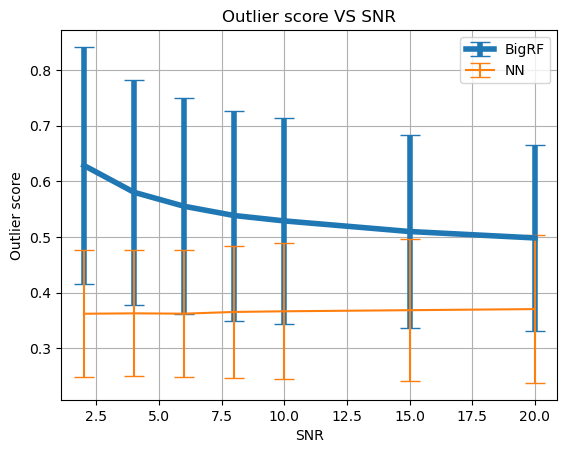

In [33]:
mean_score_BigRF = np.mean(np.mean(D_BigRF_outliers,axis=2),axis=0)
std_score_BigRF = np.std(np.mean(D_BigRF_outliers,axis=2),axis=0)
mean_score_NN = np.mean(np.mean(D_NN_outliers,axis=2),axis=0)
std_score_NN = np.std(np.mean(D_NN_outliers,axis=2),axis=0)

fig,ax = plt.subplots()
ax.errorbar(x=SNRs, y=mean_score_BigRF, yerr=std_score_BigRF, label='BigRF', capsize=7, linewidth=4)
ax.errorbar(x=SNRs, y=mean_score_NN, yerr=std_score_NN, label='NN', capsize=7)
ax.legend()
ax.grid()
ax.set_title('Outlier score VS SNR')
ax.set_xlabel('SNR')
ax.set_ylabel('Outlier score')

In [11]:
s3_inference_dir_path_in_bucket = 'almogh/thesis2/eval/inference'
D_NN = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_NN2.npy'))
D_BigRF = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_BigRF.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_NN2.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_BigRF.npy


In [34]:
NN_scores = np.mean(D_NN,axis=0)
BigRF_scores = np.mean(D_BigRF,axis=0)

In [36]:
rank_BigRF = [sum(BigRF_scores>i) for i in mean_score_BigRF]
rank_NN = [sum(NN_scores>i) for i in mean_score_NN]

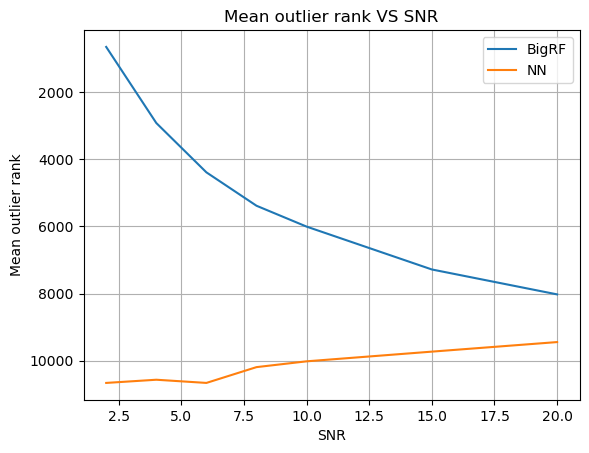

In [38]:
fig,ax = plt.subplots()
ax.errorbar(x=SNRs, y=rank_BigRF, label='BigRF')
ax.errorbar(x=SNRs, y=rank_NN, label='NN')
ax.legend()
ax.grid()
ax.set_title('Mean outlier rank VS SNR')
ax.set_xlabel('SNR')
ax.set_ylabel('Mean outlier rank')
plt.gca().invert_yaxis()